This script will compare the performance of these models:

RDN, RRDN, EDSR, SRGAN, RealESRGAN, CycleGAN, DRCT.

NOTE: Failed

In [1]:
import pandas as pd
import os
from glob import glob  
from tensorflow.image import ssim, psnr
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras import Model
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from istari_tools import (create_test_dataset,
                          calculate_metrics,
                          load_image,
                          display_image_pair,
                          load_and_preprocess,
                          create_dataset,
                          data_generator,
                          load_and_preprocess_valid_data)

# replaced mithril sharp because nor my CPU or GPU could handle it
from simple_models import (build_rdn,
                           build_rrdn,
                           build_edsr,
                           build_srgan_generator,
                           build_real_esrgan_generator,
                           build_cyclegan_generator,
                           build_cyclegan_discriminator,
                           build_drct_decoder,
                           build_drct_encoder)


2024-11-11 19:38:21.206522: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 19:38:21.206944: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 19:38:21.208930: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 19:38:21.214397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731350301.223273   67288 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731350301.22

In [2]:
tf.config.set_visible_devices([], 'GPU')

2024-11-11 19:38:22.263388: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
lr_dir = './data/DIV2K_train_LR_bicubic_X4_extracted/DIV2K_train_LR_bicubic/X4'
hr_dir = './data/DIV2K_train_HR_extracted/DIV2K_train_HR'

test_lr_dir = './data/DIV2K_valid_LR_bicubic_X4_extracted/DIV2K_valid_LR_bicubic/X4'
test_hr_dir = './data/DIV2K_valid_HR_extracted/DIV2K_valid_HR'

In [4]:
lr_files = sorted(glob(os.path.join(lr_dir, '*.png')))
hr_files = sorted(glob(os.path.join(hr_dir, '*.png')))
lr_img = Image.open(lr_files[0])
hr_img = Image.open(hr_files[0])
print(f"Low Resolution Image Shape: {lr_img.size}")
print(f"High Resolution Image Shape: {hr_img.size}")

Low Resolution Image Shape: (510, 351)
High Resolution Image Shape: (2040, 1404)


In [5]:
image_size = 510
scale_factor = 2
batch_size = 4
# changed batch_size from 16 to 4 so the kernel will not crash
num_train_images = 800

## Split data

In [6]:
lr_train_dataset = tf.keras.utils.image_dataset_from_directory(
    lr_dir,
    labels="inferred",
    label_mode=None, 
    image_size=(510, 510),
    batch_size=batch_size,
    shuffle=True
)

lr_train_dataset = lr_train_dataset.map(lambda lr_image: (lr_image, tf.image.resize(lr_image, (image_size, image_size))))

hr_train_dataset = tf.keras.utils.image_dataset_from_directory(
    hr_dir,
    labels="inferred",
    label_mode=None, 
    image_size=(2040, 2040),
    batch_size=batch_size,
    shuffle=True
)

Found 800 files.
Found 800 files.


In [8]:
# split 80% for training 20% for validation
num_train_images = int(0.8 * 800)

lr_train_data = lr_train_dataset.take(num_train_images)
lr_val_data = lr_train_dataset.skip(num_train_images)

hr_train_data = hr_train_dataset.take(num_train_images) 
hr_val_data = hr_train_dataset.skip(num_train_images) 

In [9]:
# train_dataset = JoinedGen(lr_train_data, hr_train_data)
# val_dataset = JoinedGen(lr_val_data, hr_val_data)

# train_dataset = tf.data.Dataset.zip((lr_train_data, hr_train_data))
# val_dataset = tf.data.Dataset.zip((lr_val_data, hr_val_data))

train_dataset = tf.data.Dataset.zip((lr_train_dataset, hr_train_dataset)).map(lambda lr, hr: (lr[0], hr[0]))
val_dataset = tf.data.Dataset.zip((lr_val_data, hr_val_data)).map(lambda lr, hr: (lr[0], hr[0]))

In [10]:
for (lr, hr) in train_dataset.take(1):
    print("Low-resolution image shape:", lr[0].shape)
    print("High-resolution image shape:", hr[0].shape)

Low-resolution image shape: (510, 510, 3)
High-resolution image shape: (2040, 3)


2024-11-11 18:20:20.255026: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
lr_test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_lr_dir,
    labels="inferred",
    label_mode=None, 
    image_size=(510, 510),
    batch_size=batch_size,
    shuffle=True
)

# lr_test_dataset = lr_test_dataset.map(
#     lambda x: (x, tf.image.resize(x, (image_size, image_size)))
# )

hr_test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_hr_dir,
    labels="inferred",
    label_mode=None, 
    image_size=(2040, 2040),
    batch_size=batch_size,
    shuffle=True
)

# hr_test_dataset = hr_test_dataset.map(
#     lambda x: (x, tf.image.resize(x, (image_size, image_size)))
# )

test_dataset = tf.data.Dataset.zip((lr_test_dataset, hr_test_dataset))

Found 100 files.
Found 100 files.


In [13]:
model_builders = [build_rdn, build_rrdn, build_edsr, build_srgan_generator, build_real_esrgan_generator,
                build_cyclegan_generator, build_drct_decoder]
model_names = ['RDN', 'RRDN', 'EDSR', 'SRGAN', 'RealESRGAN', 'CycleGAN', 'DRCT']

In [14]:
results_df = pd.DataFrame(columns=['Model', 'Train_Loss', 'Train_PSNR', 'Train_SSIM', 
                                   'Test_Loss', 'Test_PSNR', 'Test_SSIM'])

In [15]:
# loss and optimizer for 'RDN', 'RRDN', 'EDSR', 'SRGAN', 'RealESRGAN'
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.MeanSquaredError() 

## RDN

In [16]:
model_rdn = build_rdn(image_size)
# model_rdn.summary()

In [18]:
model_rdn.compile(optimizer=optimizer, loss=loss_fn)

model_rdn.fit(train_dataset, epochs=30, validation_data = val_dataset)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17813.6230

2024-11-09 20:13:33.473872: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - loss: 17811.9590
Epoch 2/30


2024-11-09 20:14:11.078933: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-09 20:14:11.246090: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


154/200 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - loss: 17855.2812

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17807.0898

2024-11-09 20:19:01.387693: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 17805.2051
Epoch 3/30


2024-11-09 20:19:14.556194: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17564.4746

2024-11-09 20:24:00.025379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - loss: 17563.1387
Epoch 4/30


2024-11-09 20:24:19.024183: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-09 20:24:19.175939: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16523.9922

2024-11-09 20:29:05.543586: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 16526.5430
Epoch 5/30


2024-11-09 20:29:18.720793: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17692.0215

2024-11-09 20:34:10.221730: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - loss: 17689.2305
Epoch 6/30


2024-11-09 20:34:23.321224: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16601.3594

2024-11-09 20:39:12.705436: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - loss: 16602.8867
Epoch 7/30


2024-11-09 20:39:25.799581: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17654.4414

2024-11-09 20:44:18.203662: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - loss: 17653.5723
Epoch 8/30


2024-11-09 20:44:31.233400: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-09 20:44:31.386155: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16842.1426

2024-11-09 20:49:21.096508: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 16841.7168
Epoch 9/30


2024-11-09 20:49:31.242205: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16506.0098

2024-11-09 20:54:22.659495: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - loss: 16508.6445
Epoch 10/30


2024-11-09 20:54:32.926171: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16671.4883

2024-11-09 20:59:23.762040: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - loss: 16671.1641
Epoch 11/30


2024-11-09 20:59:36.999875: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16881.3184

2024-11-09 21:04:21.967821: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - loss: 16880.5859
Epoch 12/30


2024-11-09 21:04:32.105115: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16222.0898

2024-11-09 21:09:19.782946: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - loss: 16225.1836
Epoch 13/30


2024-11-09 21:09:29.980746: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 15882.5840

2024-11-09 21:14:21.211218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 15885.8906
Epoch 14/30


2024-11-09 21:14:29.844370: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16335.0283

2024-11-09 21:19:19.992596: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - loss: 16336.1709
Epoch 15/30


2024-11-09 21:19:28.543630: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17255.2832

2024-11-09 21:24:18.723226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - loss: 17255.7715
Epoch 16/30


2024-11-09 21:24:29.093819: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-09 21:24:29.260498: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 18342.4395

2024-11-09 21:29:16.378609: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - loss: 18339.5996
Epoch 17/30


2024-11-09 21:29:29.879388: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16669.8047

2024-11-09 21:34:20.439916: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - loss: 16669.4180
Epoch 18/30


2024-11-09 21:34:29.016644: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16091.3916

2024-11-09 21:39:18.966716: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 16092.8945
Epoch 19/30


2024-11-09 21:39:29.368823: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16844.2832

2024-11-09 21:44:14.038908: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - loss: 16843.9453
Epoch 20/30


2024-11-09 21:44:22.576710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17235.8867

2024-11-09 21:49:06.345041: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - loss: 17238.6367
Epoch 21/30


2024-11-09 21:49:16.767548: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17405.6113

2024-11-09 21:54:00.585252: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - loss: 17405.3672
Epoch 22/30


2024-11-09 21:54:09.117434: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16830.3047

2024-11-09 21:58:52.987390: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - loss: 16828.9062
Epoch 23/30


2024-11-09 21:59:01.496536: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16101.9434

2024-11-09 22:03:45.578189: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - loss: 16107.2334
Epoch 24/30


2024-11-09 22:03:58.919188: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16674.2109

2024-11-09 22:08:42.701315: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - loss: 16673.9648
Epoch 25/30


2024-11-09 22:08:51.235070: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 15994.8203

2024-11-09 22:13:35.035581: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - loss: 16000.5234
Epoch 26/30


2024-11-09 22:13:43.485319: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17474.5820

2024-11-09 22:18:27.391672: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - loss: 17471.0859
Epoch 27/30


2024-11-09 22:18:37.798921: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17038.7324

2024-11-09 22:23:22.144627: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - loss: 17037.3848
Epoch 28/30


2024-11-09 22:23:30.625719: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16236.8906

2024-11-09 22:28:14.619137: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - loss: 16237.7061
Epoch 29/30


2024-11-09 22:28:23.123610: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16466.8477

2024-11-09 22:33:12.170949: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 16468.0059
Epoch 30/30


2024-11-09 22:33:22.658490: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16251.3447

2024-11-09 22:38:14.110636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - loss: 16253.7119


### RDN model evaluation

In [25]:
train_metrics = {'Loss': [], 'PSNR': [], 'SSIM': []}
for eval_lr_batch, eval_hr_batch in train_dataset:
    eval_sr_batch = model_rdn.predict(eval_lr_batch)
    train_metrics['Loss'].append(loss_fn(eval_hr_batch, eval_sr_batch).numpy())
    train_metrics['PSNR'].append(psnr(eval_hr_batch, eval_sr_batch, max_val=1.0).numpy())
    train_metrics['SSIM'].append(ssim(eval_hr_batch, eval_sr_batch, max_val=1.0).numpy())

# evaluate on test data
test_metrics = {'Loss': [], 'PSNR': [], 'SSIM': []}
for eval_lr_batch, eval_hr_batch in test_dataset:
    eval_sr_batch = model_rdn.predict(eval_lr_batch)
    test_metrics['Loss'].append(loss_fn(eval_hr_batch, eval_sr_batch).numpy())
    test_metrics['PSNR'].append(psnr(eval_hr_batch, eval_sr_batch, max_val=1.0).numpy())
    test_metrics['SSIM'].append(ssim(eval_hr_batch, eval_sr_batch, max_val=1.0).numpy())

2024-11-09 22:54:47.543728: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-11-09 22:58:40.306840: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-09 22:58:40.306992: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 212241600 bytes after encountering the first element of size 212241600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


In [34]:
results_df = pd.concat([results_df, pd.DataFrame({
    'Model': 'RDN',
    'Train_Loss': [np.mean(train_metrics['Loss'])],
    'Train_PSNR': [np.mean(train_metrics['PSNR'])],
    'Train_SSIM': [np.mean(train_metrics['SSIM'])],
    'Test_Loss': [np.mean(test_metrics['Loss'])],
    'Test_PSNR': [np.mean(test_metrics['PSNR'])],
    'Test_SSIM': [np.mean(test_metrics['SSIM'])]
})], ignore_index=True)

results_df

/tmp/ipykernel_14765/2363310200.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


,Model,Train_Loss,Train_PSNR,Train_SSIM,Test_Loss,Test_PSNR,Test_SSIM
0,RDN,16859.279297,-41.802547,0.00056,16574.007812,-41.471577,0.000837


In [21]:
model_rdn.save(f'./models_save_states/RDN.h5')

In [38]:
model_rdn.save('./models_save_states/RDN.keras')

In [36]:
results_df.to_csv('model_results.csv')

2024-11-11 18:46:37.581072: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 199756800 bytes after encountering the first element of size 199756800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-11 18:46:37.581349: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 212241600 bytes after encountering the first element of size 212241600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Min and Max of Super-Resolved Output: -1.0 1.0


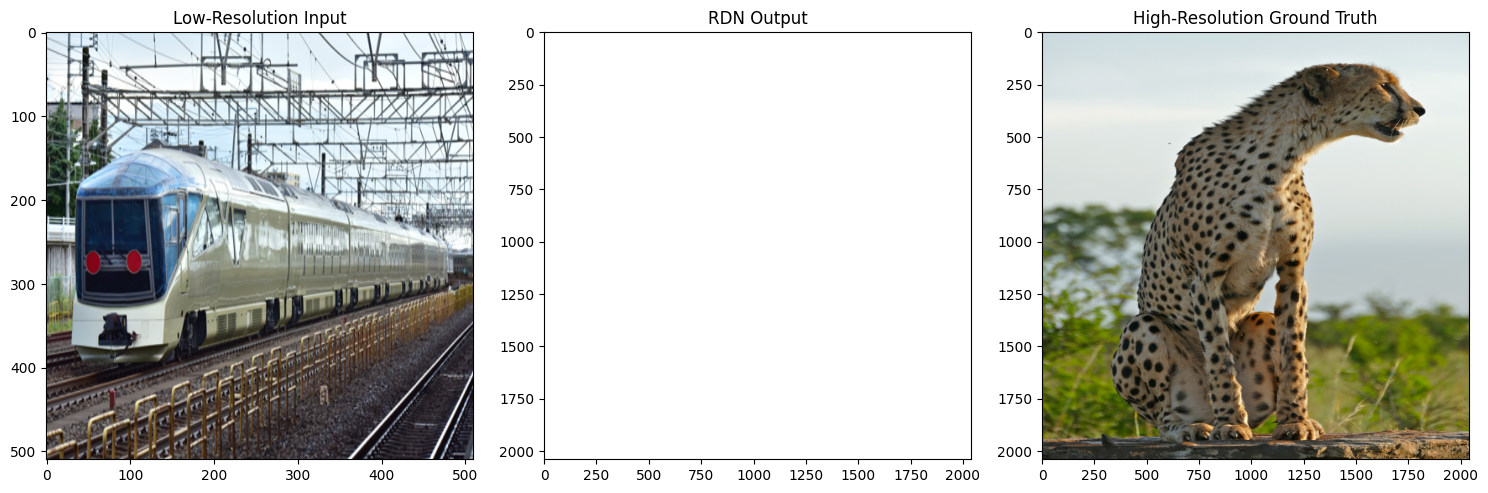

In [19]:
# visualize the output on a single image
loaded_model = keras.saving.load_model('./models_save_states/RDN.keras')


for eval_lr_batch, eval_hr_batch in test_dataset:
    eval_sr_batch = loaded_model.predict(eval_lr_batch)

    # for debugging
    print("Min and Max of Super-Resolved Output:", tf.reduce_min(eval_sr_batch).numpy(), tf.reduce_max(eval_sr_batch).numpy())

    eval_sr_batch = (eval_sr_batch + 1) / 2.0
    eval_lr_batch = eval_lr_batch / 255.0 if tf.reduce_max(eval_lr_batch) > 1 else eval_lr_batch
    eval_hr_batch = eval_hr_batch / 255.0 if tf.reduce_max(eval_hr_batch) > 1 else eval_hr_batch

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(eval_lr_batch[0])
    plt.title('Low-Resolution Input')
    plt.subplot(1, 3, 2)
    plt.imshow(eval_sr_batch[0])
    plt.title(f'RDN Output')
    plt.subplot(1, 3, 3)
    plt.imshow(eval_hr_batch[0])
    plt.title('High-Resolution Ground Truth')
    plt.tight_layout()
    plt.savefig(f'./img/RDN_output.png')
    # Close the figure to free memory
    plt.show()
    plt.close()

    break

## ESDR

In [7]:
model = build_edsr(image_size, scale_factor=4)

In [8]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - loss: 15899.9326
Epoch 2/50


2024-11-02 18:15:55.074276: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


40/40 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - loss: 15715.9795
Epoch 3/50


2024-11-02 18:19:16.759359: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - loss: 15727.2441
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 219s 5s/step - loss: 15826.5449
Epoch 5/50


2024-11-02 18:26:24.910460: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 219s 5s/step - loss: 15705.3027
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 224s 6s/step - loss: 15873.6777
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 222s 6s/step - loss: 15822.3262
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - loss: 15484.2803
Epoch 9/50


2024-11-02 18:41:05.680261: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 222s 6s/step - loss: 15670.1084
Epoch 10/50
20/40 ━━━━━━━━━━━━━━━━━━━━ 1:47 5s/step - loss: 15597.9316

In [ ]:
model.save('./models_save_states/trial_edst.h5')

In [ ]:
# test the model 
test_lr_files = [f for f in os.listdir(test_lr_dir) if f.endswith('.png')]
test_hr_files = [f for f in os.listdir(test_hr_dir) if f.endswith('.png')]

test_dataset = create_test_dataset(test_lr_files, test_hr_files, test_hr_dir, test_lr_dir, image_size, scale_factor)

sr_images = []
hr_images = []

for lr_img, hr_img in test_dataset:
    sr_img = model(lr_img)
    sr_images.append(sr_img[0].numpy())
    hr_images.append(hr_img[0].numpy())

# PSNR and SSIM
metrics = calculate_metrics(hr_images, sr_images)
print(metrics)

## Loop over all models

In [ ]:
for model_builder, model_name in zip(model_builders, model_names):
    print(f'Training {model_name} model...')

    if model_name == 'DRCT':
        model = build_drct_encoder(image_size, scale_factor=4)
        decoder = build_drct_decoder(image_size, scale_factor=4)
        # loss function for the encoder and a loss function for the decoder (may need modifications for DRCT) 
        loss_fn_encoder = tf.keras.losses.MeanSquaredError()
        loss_fn_decoder = tf.keras.losses.MeanSquaredError()  
        optimizer_encoder = tf.keras.optimizers.Adam(learning_rate=1e-4)
        optimizer_decoder = tf.keras.optimizers.Adam(learning_rate=1e-4)

        model.compile(optimizer=optimizer_encoder, loss=loss_fn_encoder)
        decoder.compile(optimizer=optimizer_decoder, loss=loss_fn_decoder)
    
        model = tf.keras.models.Sequential([model, decoder])
        model.compile(optimizer='adam', loss='mse')
    
    elif model_name == 'CycleGAN':
        # Create generators and discriminators
        gen_A2B = build_cyclegan_generator(image_size)
        gen_B2A = build_cyclegan_generator(image_size)
        disc_A = build_cyclegan_discriminator(image_size)
        disc_B = build_cyclegan_discriminator(image_size)

        # Loss weights
        lambda_cycle = 10.0
        lambda_identity = 0.5

        # Optimizers
        generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

        # Loss functions
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        mse = tf.keras.losses.MeanSquaredError()

        @tf.function
        def train_step(real_A, real_B):
            with tf.GradientTape(persistent=True) as tape:
                # Generate fake images
                fake_B = gen_A2B(real_A, training=True)
                fake_A = gen_B2A(real_B, training=True)

                # Cycle consistency
                cycled_A = gen_B2A(fake_B, training=True)
                cycled_B = gen_A2B(fake_A, training=True)

                # Identity mapping
                same_A = gen_B2A(real_A, training=True)
                same_B = gen_A2B(real_B, training=True)

                # Discriminator outputs
                disc_real_A = disc_A(real_A, training=True)
                disc_fake_A = disc_A(fake_A, training=True)
                disc_real_B = disc_B(real_B, training=True)
                disc_fake_B = disc_B(fake_B, training=True)

                # Generator losses
                gen_A2B_loss = cross_entropy(tf.ones_like(disc_fake_B), disc_fake_B)
                gen_B2A_loss = cross_entropy(tf.ones_like(disc_fake_A), disc_fake_A)

                # Cycle consistency losses
                cycle_A_loss = mse(real_A, cycled_A)
                cycle_B_loss = mse(real_B, cycled_B)
                total_cycle_loss = cycle_A_loss + cycle_B_loss

                # Identity losses
                identity_A_loss = mse(real_A, same_A)
                identity_B_loss = mse(real_B, same_B)

                # Total generator losses
                total_gen_A2B_loss = (gen_A2B_loss + 
                                    lambda_cycle * total_cycle_loss +
                                    lambda_identity * identity_B_loss)
                total_gen_B2A_loss = (gen_B2A_loss + 
                                    lambda_cycle * total_cycle_loss +
                                    lambda_identity * identity_A_loss)

                # Discriminator losses
                disc_A_loss = 0.5 * (
                    cross_entropy(tf.ones_like(disc_real_A), disc_real_A) +
                    cross_entropy(tf.zeros_like(disc_fake_A), disc_fake_A)
                )
                disc_B_loss = 0.5 * (
                    cross_entropy(tf.ones_like(disc_real_B), disc_real_B) +
                    cross_entropy(tf.zeros_like(disc_fake_B), disc_fake_B)
                )

            # Calculate and apply gradients
            gen_A2B_gradients = tape.gradient(total_gen_A2B_loss, gen_A2B.trainable_variables)
            gen_B2A_gradients = tape.gradient(total_gen_B2A_loss, gen_B2A.trainable_variables)
            disc_A_gradients = tape.gradient(disc_A_loss, disc_A.trainable_variables)
            disc_B_gradients = tape.gradient(disc_B_loss, disc_B.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_A2B_gradients, gen_A2B.trainable_variables))
            generator_optimizer.apply_gradients(zip(gen_B2A_gradients, gen_B2A.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_A_gradients, disc_A.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_B_gradients, disc_B.trainable_variables))

            return {
                'gen_total_loss': total_gen_A2B_loss + total_gen_B2A_loss,
                'disc_total_loss': disc_A_loss + disc_B_loss
            }

        # Train the model
        for epoch in range(50):
            for batch_A, batch_B in train_dataset:
                losses = train_step(batch_A, batch_B)
            
        # Use gen_A2B as the final model for evaluation
        model = gen_A2B

    else:
        model = model_builder(image_size, scale_factor=4)
        # Loss and Optimizer (shared for all models except DRCT)
        loss_fn = tf.keras.losses.MeanSquaredError() 
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        model.compile(optimizer=optimizer, loss=loss_fn)  

    model.fit(train_dataset, epochs=50, validation_data=val_dataset)

    print(f'Evaluating {model_name} model...')

    # evaluate on training data
    train_metrics = {'Loss': [], 'PSNR': [], 'SSIM': []}
    for eval_lr_batch, eval_hr_batch in train_dataset:
        eval_sr_batch = model.predict(eval_lr_batch)
        train_metrics['Loss'].append(loss_fn(eval_hr_batch, eval_sr_batch).numpy())
        train_metrics['PSNR'].append(psnr(eval_hr_batch, eval_sr_batch, max_val=1.0).numpy())
        train_metrics['SSIM'].append(ssim(eval_hr_batch, eval_sr_batch, max_val=1.0).numpy())

    # evaluate on test data
    test_metrics = {'Loss': [], 'PSNR': [], 'SSIM': []}
    for eval_lr_batch, eval_hr_batch in test_dataset:
        eval_sr_batch = model.predict(eval_lr_batch)
        test_metrics['Loss'].append(loss_fn(eval_hr_batch, eval_sr_batch).numpy())
        test_metrics['PSNR'].append(psnr(eval_hr_batch, eval_sr_batch, max_val=1.0).numpy())
        test_metrics['SSIM'].append(ssim(eval_hr_batch, eval_sr_batch, max_val=1.0).numpy())
    
    results_df = results_df.append({
        'Model': model_name,
        'Train_Loss': np.mean(train_metrics['Loss']),
        'Train_PSNR': np.mean(train_metrics['PSNR']),
        'Train_SSIM': np.mean(train_metrics['SSIM']),
        'Test_Loss': np.mean(test_metrics['Loss']),
        'Test_PSNR': np.mean(test_metrics['PSNR']),
        'Test_SSIM': np.mean(test_metrics['SSIM'])
    }, ignore_index=True)

    # visualize the output on a single image
    eval_lr_batch, eval_hr_batch = next(iter(train_dataset))
    eval_sr_batch = model.predict(eval_lr_batch)

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(eval_lr_batch[0])
    plt.title('Low-Resolution Input')
    plt.subplot(1, 3, 2)
    plt.imshow(eval_sr_batch[0])
    plt.title(f'{model_name} Output')
    plt.subplot(1, 3, 3)
    plt.imshow(eval_hr_batch[0])
    plt.title('High-Resolution Ground Truth')
    plt.tight_layout()
    plt.savefig(f'./img/{model_name}_output.png')
    # Close the figure to free memory
    plt.show()
    plt.close()

    model.save(f'./models_save_states/{model_name}.h5')

In [ ]:
print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))

In [ ]:
# comparative metrics
plt.figure(figsize=(15, 5))

# PSNR comparison
plt.subplot(1, 3, 1)
plt.bar(results_df['Model'], results_df['Test_PSNR'])
plt.title('PSNR Comparison')
plt.xticks(rotation=45)

# SSIM comparison
plt.subplot(1, 3, 2)
plt.bar(results_df['Model'], results_df['Test_SSIM'])
plt.title('SSIM Comparison')
plt.xticks(rotation=45)

# Loss comparison
plt.subplot(1, 3, 3)
plt.bar(results_df['Model'], results_df['Test_Loss'])
plt.title('Loss Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()